# Mission Design- Satellite Tracking

- **Author -** *[Neelay Doshi](https://github.com/neelaydoshi)*

## Instruction for Running this Notebook

**Create a conda environment :**

- `conda create -n my_venv python=3.10`

- `conda activate my_venv`


**Install the necessary libraries :**

- `pip install ipykernel numpy matplotlib`

- `pip install skyfield`



## Objective


- Track an object that is orbiting Earth, with *either* a space-based tracker or a ground-based tracker, for the next one day from the given epoch.
- I have chosen to track it with the **ground-based tracker**.
- The TLE of the object ([DROID.002](https://www.n2yo.com/satellite/?s=63223) satellite) have been provided in the question.
- The location coordinates of the ground-based tracker ([Ny-Ålesund Geodetic Observatory](https://space-geodesy.nasa.gov/NSGN/sites/Ny_Alesund/Ny_Alesund.html)) has been probided in the question.
- The **field of regard** of the site is $70$ degrees.
- Additionally, for the ground station to be able to detect the satellite, the satellite must be sunlit, while the station must be in the night side of Earth.
- To Do:
    - Find the number of **crossing** event(s) in the next one day starting from the given epoch of the tracker.
    - Check if the object is **visible/detectable** during any of the aforementioned **crossing** events.
    - The minimum desired output is **start and end time** of the crossing and detection envet(s).




## Results for Ground-Based Sensor 

**A quick glance at the results :**

<p align="center">
  <img src="./satellite_trajectory_1.6h.png" width="1000" />
  <br>
  <b>Figure 1: Satellite ground track and position coordinates. </b>
</p>


**Crossing Events :** 

The object is within the $70^\circ$ *field of regard* of the station (but not necessarily visible). There are 4 crossing events in total:

1. `start: 2025-09-01 00:29:48 UTC | end: 2025-09-01 00:31:20 UTC | duration: 1.5 min`

2. `start: 2025-09-01 02:04:12 UTC | end: 2025-09-01 02:04:37 UTC | duration: 0.4 min`

3. `start: 2025-09-01 05:11:31 UTC | end: 2025-09-01 05:12:01 UTC | duration: 0.5 min`

4. `start: 2025-09-01 06:44:51 UTC | end: 2025-09-01 06:46:23 UTC | duration: 1.5 min`


**Visibility Event :** 

The object is in the $70^\circ$ *field of regard* of the station and is sunlit, while the station is in the night side of Earth. The ground-based tracker will be able to view the object in only on of the 4 corssing events:

1. `start: 2025-09-01 00:29:48 UTC | end: 2025-09-01 00:31:20 UTC | duration: 1.5 min`


## Approach

**My approach has been as follows:**

- Given that the task it to track the satellite in orbit, I have first attempted to visualize the satellite and the ground station in a 3D space, and do some simple hand-calculation, so that I can obtain some intutive idea of what result to expect. (Note: These preliminary results will NOT be used in the solution porgram.) 

- This notebook is divided into the following sections: 
    1. **Interpretation of Data:** given in the assignment. 
    2. **Preliminary Analysis:** of the given information with some visualization and simple hand-calculations.
    3. **Python Program:** I have used [Skyfield](https://github.com/skyfielders/python-skyfield) to simulate the object's motion in orbit and its tracking by the ground-based tracker, and thus find windows of *crossing(s)* and *detection(s)*.
    4. **Results and Conclusion**


## 1. Interpretation of Data

### Interpretation of Object's TLE

**The given TLE of the object are :**

`1 63223U 25052P   25244.59601767  .00010814  00000-0  51235-3 0  9991` <br>
`2 63223  97.4217 137.0451 0006365  74.2830 285.9107 15.19475170 25990`

**[DROID.002](https://www.n2yo.com/satellite/?s=63223) Satellite :**

- As per the [space-track.org](https://www.space-track.org/documentation#tle) documentation, the very first element of the TLE `63223U` gives the satellite catalog number. So the given object correspond to the [DROID.002](https://www.n2yo.com/satellite/?s=63223) satellite. 


**TLE Date and Time: `2025-09-01 14:18:16 UTC`**
- The third element of the TLE `25244.59601767` gives the exact time at which the various orbital parameters were recorded. This value corresponds `2025-09-01 14:18:16 UTC`.


In [1]:
# ------------------------------------------------
# TLE Time
# ------------------------------------------------
hrs = 0.59601767*24
min = ( (hrs % 1) * 60 )
sec = ( min % 1 ) * 60
print(f"TLE Time => {hrs:.0f}:{min:.0f}:{sec:.0f}")


TLE Time => 14:18:16


**Orbital Parameters :**

- The satelllite has a high inclination of $97.4217^\circ$, meaning it is in  polar orbit. 
- The eccentricity is very small `0.0006365`, so it almost a circular orbit.
- The object orbits the Earth `15.19475170` times per day. Meaning it has a low altitude (LEO).


### Ground-Based Station

**Location coordinates :**
- Latitude: 78.9066 deg 
- Longitude: 11.88916 deg 
- Altitude (MSL): 380 m 
- Based on the coordinates, this seems to be the [Ny-Ålesund Geodetic Observatory](https://space-geodesy.nasa.gov/NSGN/sites/Ny_Alesund/Ny_Alesund.html) in Svalbard, Norway, which uses "satellite laser ranging system" (SLR) for determining the position of satellites.


**Field of Regard :**
- $70$ degrees
- So the half-cone angle is $35^\circ$, meaning the satellite must be $55^\circ$ ($90^\circ-35^\circ$) above the horizon, for it to be visible to the ground station.





## 2. Preliminary Analysis 

**Note :**
- The simple hand-calculations done in this section are just to obtain an intuition of the problem statement and to serve as a sanity check of the solution that the program will generate.
- The values computed in this section have NOT been used in the programming section.


### Epoch and Object TLE

**Time of Epoch and Object TLE :**

- `2025-09-01 00:00:00 UTC` : Epoch Start Time

- `2025-09-01 14:18:16 UTC` : Object TLE Time

- `2025-09-02 00:00:00 UTC` : Epoch End Time


**Interpretation :**
- The objects TLE is just 14 hours ahead of the epoch start time and 10 hours before epoch end time. This is good, because the time difference is not very large and so the `SPG4` propagator can compute the orbital parameters of the object quite accurately for the 24 hours time frame.


### Object Orbit and Ground Station Location

In [2]:
# ------------------------------------------------
# Compute average altitude of the object
# ------------------------------------------------
# -> given that the eccentricity is almost 0, we can assume circular orbit...
# -> just for this preliminary analysis
# ------------------------------------------------

import numpy as np

G       = 6.674e-11 # universal gravitational constant (in m^3/kgs^2)
M       = 5.972e24 # mass of earth (in kg)
num_rev = 15.19475170 # revolutions/day of the object
T       = 24*60*60/15.19475170 # time period of 1 orbit (in s)
R_earth = 6371e3 # avg radius of earth (in m)
R_obj   = ( G*M*T**2 / (4*np.pi**2) )**(1/3) # avg radius of orbit of obj (in m)
alt_obj = R_obj - R_earth

print("-"*47)
print(f"Average Altitude of Object : {alt_obj/1000:.0f} km")
print("-"*47)


-----------------------------------------------
Average Altitude of Object : 514 km
-----------------------------------------------


**Some Numbers :**

- The station is located at a very high latitude of $78.9^\circ$, close to the North pole. This location is great for tracking objects in polar orbit. 

- The object is in polar orbit and reaches a maximum latitude of about $180^\circ-97.4^\circ = 82.6^\circ$.

- The object completes `~15.19` revolutions/day, meaning it completes 1 revolution every `~01:35` hours. 

- Given the high latitude, the ground station experiences *midnight sun* phenomenon during summer, approximately from mid April to mid Aug. Thankfully, the epoch given on $1^{st}$ September. A simple google search suggests that during Spetember, Svalbard usually experiences night from `10:00 pm` to `03:30 am` (local time). So there is a maximum of `~5.5 hours` window for detecting the object.

**Interpretation :** 
- So given the high latitude and low *FOR* (Field of Regard) of the station, coupled with the fact that the object is in LEO (about 514 km altitude) and thus has a small orbital period, the number of windows of **crossing will be few** and the **duration will also be small**.

- During September, Svalbard follows the CEST time and thus it is `+2 hrs` ahead of UTC time. Since the epoch given in the question is from `00:00:00 hrs` UTC for the next `24 hours`, meaning the epoch starts at `02:00:00 hrs` in Svalbard. Based on this informations, we can predict the possible **visibility windows** for observing the object:
    - **Window-1 :** `00:00:00 UTC` to `01:30:00 UTC` (since sunrise occurs at `03:30 am` local time in Svalbard).
    - **Window-2 :** `20:00:00 UTC` to `23:59:59 UTC` (since sunset occurs at `10:00 pm` local time in Svalbard).

- Now, since the time-period of the object is `~01:35` hrs, this means that there can be atmost 1 visibility event in *window-1* and atmost 2 visibility event in the *window-2*. Thus, there can be **atmost 3 visiblitity events** in total.
    


## 3. Python Program

### Visualize Orbit

Lets first visualize the orbit of the satellite using the [Skyfield](https://github.com/skyfielders/python-skyfield) python library. 

- This is done by loading the object’s `TLE` and building an `EarthSatellite()` instance. `Skyfield` propagates the orbit using the standard `SGP4` model (Simplified General Perturbations 4), which is a fast analytical propagator. The propagation produces satellite states in the `TEME` (True Equator, Mean Equinox) reference frame. 

- To plot the ground track, `Skyfield` converts the Earth-centered position into an Earth-fixed frame `ITRS` (International Terrestrial Reference System). It  then computes geodetic latitude/longitude/height using the built-in [WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System) ellipsoid (accounting for Earth’s flattening): converting the Cartesian satellite position into the  lat/long/alt.

- Since the object's time period of one orbit is about `~95 min`, we will plot only the first `~95 min` trajectory of the satellite from the epoch, so as to avoid cluttering the plot.


**Compute Latitude, Longitude and Altitude of the Object During a Single Revolution :**

In [3]:
# Import libraries
from skyfield.api import load, EarthSatellite, wgs84
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
  
# TLE data  
line1 = "1 63223U 25052P   25244.59601767  .00010814  00000-0  51235-3 0  9991"
line2 = "2 63223  97.4217 137.0451 0006365  74.2830 285.9107 15.19475170 25990"

# Load timescale and create satellite object  
ts          = load.timescale() # skyfield.timelib.Timescale
satellite   = EarthSatellite(line1, line2, 'SAT-63223', ts) # skyfield.sgp4lib.EarthSatellite

# Generate time array
t_start = 0 # in hrs
dt      = 1/60 # in hours
t_end   = 1.6 # in hrs
hours   = np.arange(t_start, t_end+dt, dt) # every dt minutes for 24 hours
times   = ts.utc(2025, 9, 1, 0, 0, hours*3600) # skyfield.timelib.Time

# Calculate satellite positions  
geocentric = satellite.at(times) # skyfield.positionlib.Geocentric
  
# Get latitude, longitude, and altitude  
lat, lon = wgs84.latlon_of(geocentric)  
altitude = wgs84.height_of(geocentric)

# print max latitude attained by object
print("-"*47)
print(f"Object Max Latitude         : {np.max(lat.degrees):.2f} deg")
print(f"Object [Min, Max] Altitude  : [{np.min(altitude.km):.0f}, {np.max(altitude.km):.0f}] km")
print("-"*47)


-----------------------------------------------
Object Max Latitude         : 82.43 deg
Object [Min, Max] Altitude  : [508, 540] km
-----------------------------------------------


**Plot Trajectory :**

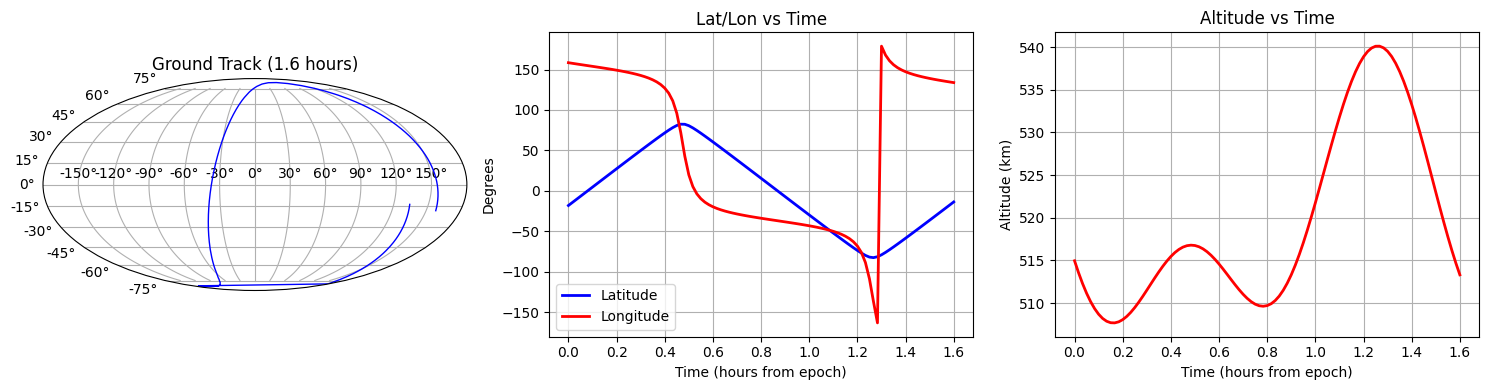

In [4]:
# Create the plot  
fig = plt.figure(figsize=(15, 4))

# Sub-plot 1: Ground track  
ax1 = plt.subplot(1, 3, 1, projection='mollweide')
ax1.plot(lon.radians, lat.radians, 'b-', linewidth=1)
ax1.set_title(f'Ground Track ({t_end} hours)')
ax1.grid(True)

# Sub-plot 2: Latitude/Longitude over time
ax2 = plt.subplot(1, 3, 2)
ax2.plot(hours, lat.degrees, 'b-', label='Latitude', linewidth=2)
ax2.plot(hours, lon.degrees, 'r-', label='Longitude', linewidth=2)
ax2.set_xlabel('Time (hours from epoch)')
ax2.set_ylabel('Degrees')
ax2.set_title('Lat/Lon vs Time')
ax2.legend()
ax2.grid(True)

# Sub-plot 3: Altitude over time
ax3 = plt.subplot(1, 3, 3)
ax3.plot(hours, altitude.km, 'r-', linewidth=2)
ax3.set_xlabel('Time (hours from epoch)')
ax3.set_ylabel('Altitude (km)')
ax3.set_title('Altitude vs Time')
ax3.grid(True)

plt.tight_layout()
plt.savefig(f'satellite_trajectory_{t_end}h.png', dpi=150)
plt.show()



**Interpretation :**

- The maximum latitude of the satellite is `82.43 deg` and the altitude range is between `[508, 540] km`, which is inline with the values we expected in the *Preliminary Analysis* section.

- Upon inspecting the *Ground Track* plot and the *Latitude/Longitude vs Time* plot, we can see that in the time range `t = 0.4 hrs` to `t = 0.6 hrs`, the object is at its highest latitude `~82 deg`, which is close to the latitude of the ground-based tracker (`~79 deg`). Moreover, the object crosses a large range of longitude, including the `~12 deg` where the ground-based tracker is positioned. Thus there is a good possiblitly of a **crossing event**.

- Recall that in the *Preliminary Analysis* section we had deduced that the ground station will be in the night time during the time range `00:00:00 UTC` to `01:30:00 UTC`  as well as `20:00:00 UTC` to `23:59:59 UTC`. The above plots correspond to the *window-1*, so there is a possiblity that the object might be on the sunlit side and withing the *field of regard* of the ground-based tracker, and thus a **detection event**.



### Find Crossing Events

**Programming Logic :**

1. Initialize `satellite` and `station` objects using the given TLE and lat/lon/alt coordinates:
    - The `satellite` object uses `SGP4` to compute the orbital parameters for various time.

    - The `station` object uses `WGS 84` internally to convert lat/lon/alt to x/y/z Cartesian coordinates.


2. Initialize the start and end time of the epoch `t0` and `t1`.


3. Find the crossing events using the `find_events` in-built function of the `satellite` object:
    - Thus function takes considers the position of the `station` as well as its *field of regard* in terms of `altitude_degree` argument, which is the minimum elevation threshold above the horizon that the station can view an object.

    - It also takes the start and end time (`t0`, `t1`) of the epoch as input.

    - It outputs the `events`, which can be either rising, culminate or setting of a satellite (w.r.t the threshold) and their corresponding time are stored in `t_events`.


4. We then iterate over these events and store them in a Python tuple as `windows = (t_start, t_end)` 

5. Finally, print the corssing windows timings and their duration.


In [ ]:
# Import libraries
import numpy as np
from skyfield.api import load, EarthSatellite, wgs84

# TLE of the object
line1 = "1 63223U 25052P   25244.59601767  .00010814  00000-0  51235-3 0  9991"
line2 = "2 63223  97.4217 137.0451 0006365  74.2830 285.9107 15.19475170 25990"

# Ground-based tracker coordinates
gs_lat      = 78.9066
gs_lon      = 11.88916
gs_alt_m    = 380.0

# Create object and ground-tracker instance
satellite   = EarthSatellite(line1, line2, "DROID.002", ts)
station     = wgs84.latlon(gs_lat, gs_lon, elevation_m=gs_alt_m)

# Time window (24h)
ts = load.timescale(builtin=True)
t0 = ts.utc(2025, 9, 1, 0, 0, 0) # epoch start
t1 = ts.utc(2025, 9, 2, 0, 0, 0) # epoch end

# Find crossing windows above min-elevation threshold
# -> Convert Field-of-Regard to Min-Elevation-Threshold (for Skyfield)
# -> 70 deg full-cone angle => half-angle 35 deg from zenith => min elev = 90-35 = 55 deg
# -> events: 0 = rise above threshold, 1 = culminate, 2 = set below threshold
min_elev_deg        = 55.0
t_events, events    = satellite.find_events(station, t0, t1, altitude_degrees=min_elev_deg)

# Initialize parameters for storage
windows = [] # will store (start_time, end_time) for each visible pass
current_start = None # remembers the most recent "rise" time

# Loop over each event returned by Skyfield
for ti, ev in zip(t_events, events):
    
    # event 0: satellite rises above the elevation threshold
    if ev == 0: current_start = ti # start a new visibility window at this time        

    # event 1: culminate [skip]
    elif ev == 1: pass

    # event 2: satellite sets below the elevation threshold
    elif ev == 2: 
        if current_start is not None: # only close a window if we previously saw a rise
            windows.append((current_start, ti)) # store (start, end) time
            current_start = None # reset for the next pass

# Print summary
print("-" * 87)
print(f"Min elevation threshold             : {min_elev_deg:.1f} deg")
print(f"Number of crossing windows in 24h   : {len(windows)} crossing windows")
print("-" * 87)

# Print all the crossing events/windows
for k, (a, b) in enumerate(windows):
    dur_s = (b.utc_datetime() - a.utc_datetime()).total_seconds()  # duration in seconds
    print(f"{k:02d}) start: {a.utc_strftime('%Y-%m-%d %H:%M:%S')} UTC"
          f" | end: {b.utc_strftime('%Y-%m-%d %H:%M:%S')} UTC"
          f" | duration: {dur_s/60:.1f} min")

print("-" * 87)


---------------------------------------------------------------------------------------
Min elevation threshold             : 55.0 deg
Number of crossing windows in 24h   : 4 crossing windows
---------------------------------------------------------------------------------------
00) start: 2025-09-01 00:29:48 UTC | end: 2025-09-01 00:31:20 UTC | duration: 1.5 min
01) start: 2025-09-01 02:04:12 UTC | end: 2025-09-01 02:04:37 UTC | duration: 0.4 min
02) start: 2025-09-01 05:11:31 UTC | end: 2025-09-01 05:12:01 UTC | duration: 0.5 min
03) start: 2025-09-01 06:44:51 UTC | end: 2025-09-01 06:46:23 UTC | duration: 1.5 min
---------------------------------------------------------------------------------------


### Find Visibility Events

**Programming Logic :**

1. Now that we have the list of crossing windows, we need to check if the satellite will be visible in any of these windows. For the satellite to be visible, the satellite must be sunlit while the station must be in the dark. We will use the Skyfield's inbuilt function: 

    - `.is_sunlit()` to check if the satellite is sunlit.

    - `dark_twilight_day()` to check if the station is in the dark.

2. It is possible that the aforementioned conditions might be satisfied for only a fraction of the crossing window. So we will discretizing the crossing window it into time-steps of `step_s = 1s`, and check the satisfaction of the condition for each of the time-step. The start and end time of the visible window will be stored in `visible_window` variable.

3. Finally, we will print all the visible windows along with the duration of visibility of the satellite.


In [6]:
from skyfield.almanac import dark_twilight_day
import numpy as np

# Assumptions for filtering
step_s = 1 # sample resolution (seconds)

# Ephemeris needed for sunlit + twilight/day/night
eph = load("de421.bsp")

# Function: 0..4 (dark/twilight/day)
# -> 0 dark, 1 astro, 2 nautical, 3 civil, 4 sun up
# -> treat "night" as anything except Sun-up (state 4)
dt_state = dark_twilight_day(eph, station)

# Store visible window
visible_windows = []

# Iterate over all the crossing windows
for (a, b) in windows:
    total_s = (b.utc_datetime() - a.utc_datetime()).total_seconds()
    if total_s <= 0:
        continue

    # Build a time grid inside this pass window
    sec_arr = np.arange(0.0, total_s, step_s) # arrray of time-steps
    adt     = a.utc_datetime() # converts the Skyfield start time a into a normal Python datetime
    asec    = adt.second + adt.microsecond/1e6 # preserve micorseconds as well
    tgrid   = ts.utc(adt.year, adt.month, adt.day, adt.hour, adt.minute, asec + sec_arr) # skyfield time array

    # Conditions per sample time
    sat_sunlit      = np.asarray(satellite.at(tgrid).is_sunlit(eph)) # True if satellite is sunlit
    station_dark    = np.asarray(dt_state(tgrid) != 4) # True for all except "Sun is up = 4"

    # Check condition: satellite-sunlit AND station-in-dark
    ok = sat_sunlit & station_dark

    # Convert boolean samples -> (start, end) sub-windows
    # (to check the exact span of the "corsssing window" for which the satellite was visible)
    in_run  = False # boolean for check if its a continuous streach of time
    start_i = 0

    # loop over the entire window with time-step = step_s 
    for i, flag in enumerate(ok):
        if flag and not in_run:
            in_run  = True # satellite is visible
            start_i = i # record the time-step
        
        # check if no longer satellite visible (was visible previously)
        elif (not flag) and in_run:
            visible_windows.append((tgrid[start_i], tgrid[i-1]))
            in_run = False

    # satellite was visible during the entire corsssing window
    if in_run:
        visible_windows.append((tgrid[start_i], tgrid[-1]))

# Print visibility events/windows
print("-"*87)
print(f"Visible windows (sunlit sat + station night): {len(visible_windows)}")
print("-"*87)
for k, (a, b) in enumerate(visible_windows, 1):
    dur_s = (b.utc_datetime() - a.utc_datetime()).total_seconds()
    print(f"{k:02d}) start: {a.utc_strftime('%Y-%m-%d %H:%M:%S')} UTC"
          f" | end: {b.utc_strftime('%Y-%m-%d %H:%M:%S')} UTC"
          f" | duration: {dur_s/60:.1f} min")
print("-"*87)


---------------------------------------------------------------------------------------
Visible windows (sunlit sat + station night): 1
---------------------------------------------------------------------------------------
01) start: 2025-09-01 00:29:48 UTC | end: 2025-09-01 00:31:20 UTC | duration: 1.5 min
---------------------------------------------------------------------------------------


## 4. Results and Conclusion

**Crossing Events :**

There are 4 crossing events in total:

1. `start: 2025-09-01 00:29:48 UTC | end: 2025-09-01 00:31:20 UTC | duration: 1.5 min`

2. `start: 2025-09-01 02:04:12 UTC | end: 2025-09-01 02:04:37 UTC | duration: 0.4 min`

3. `start: 2025-09-01 05:11:31 UTC | end: 2025-09-01 05:12:01 UTC | duration: 0.5 min`

4. `start: 2025-09-01 06:44:51 UTC | end: 2025-09-01 06:46:23 UTC | duration: 1.5 min`


**Visibility Event :**

The ground-based tracker will be able to view the object in only on of the 4 corssing events:

1. `start: 2025-09-01 00:29:48 UTC | end: 2025-09-01 00:31:20 UTC | duration: 1.5 min`


**Inference :**

- As we had expected in the *Preliminary Analysis* section, the duration of all the crossing events is quite short (about a minute), due to the trackers high latitude position and small *field of regard*. 

- The object detection occurs at `00:29:48 UTC`, which is inline with the sanity check done in the *Preliminary Analysis* section, since the ground-based tracker is on the night side of the Earth in the time window `00:00:00 UTC` to `01:30:00 UTC`.
